# 정형 데이터와 함께 LLM 사용하기

## 파이썬으로 관계형 DB 다루기

In [1]:
import sqlite3
import pandas as pd
## 데이터베이스에 연결
database = 'chinook.db'


conn = sqlite3.connect(database)

## 테이블 가져오기
tables = pd.read_sql("""SELECT name, type
                        FROM sqlite_master
                        WHERE type IN ("table", "view");""", conn)

tables

,name,type
0,albums,table
1,sqlite_sequence,table
2,artists,table
3,customers,table
4,employees,table
5,genres,table
6,invoices,table
7,invoice_items,table
8,media_types,table
9,playlists,table


In [2]:
pd.read_sql("""PRAGMA table_info(customers);""",conn)

,cid,name,type,notnull,dflt_value,pk
0,0,CustomerId,INTEGER,1,None,1
1,1,FirstName,NVARCHAR(40),1,None,0
2,2,LastName,NVARCHAR(20),1,None,0
3,3,Company,NVARCHAR(80),0,None,0
4,4,Address,NVARCHAR(70),0,None,0
5,5,City,NVARCHAR(40),0,None,0
6,6,State,NVARCHAR(40),0,None,0
7,7,Country,NVARCHAR(40),0,None,0
8,8,PostalCode,NVARCHAR(10),0,None,0
9,9,Phone,NVARCHAR(24),0,None,0


In [3]:
pd.read_sql("""
SELECT c.country AS Country, SUM(i.total) AS Sales
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY Country
ORDER BY Sales DESC
LIMIT 5;

""", conn)

,Country,Sales
0,USA,523.06
1,Canada,303.96
2,France,195.10
3,Brazil,190.10
4,Germany,156.48


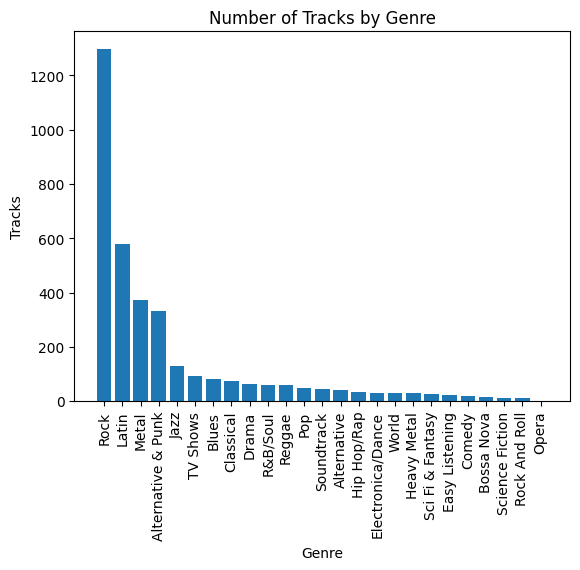

In [4]:
import matplotlib.pyplot as plt

# SQL 질의를 정의
sql = """
SELECT g.Name AS Genre, COUNT(t.TrackId) AS Tracks
FROM genres g
JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY Genre
ORDER BY Tracks DESC;
"""

# 데이터프레임을 생성
data = pd.read_sql(sql, conn)

# Plot the data as a bar chart
plt.bar(data.Genre, data.Tracks)
plt.title("Number of Tracks by Genre")
plt.xlabel("Genre")
plt.ylabel("Tracks")
plt.xticks(rotation=90)
plt.show()

## 랭체인 에이전트 및 SQL 에이전트

In [5]:
import os
from dotenv import load_dotenv

load_dotenv()

#os.environ["HUGGINGFACEHUB_API_TOKEN"]
openai_api_key = os.environ['OPENAI_API_KEY']


In [6]:
from langchain_community.agent_toolkits import create_sql_agent
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase
from langchain.agents import AgentExecutor
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

db = SQLDatabase.from_uri('sqlite:///chinook.db')

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
agent_executor = create_sql_agent(
    llm=llm,
    toolkit=toolkit,
    verbose=True,
)

In [7]:
[tool.name for tool in toolkit.get_tools()]

['sql_db_query', 'sql_db_schema', 'sql_db_list_tables', 'sql_db_query_checker']

In [8]:
agent_executor.invoke("playlist_track 테이블 구조를 한국어로 알려줘")



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables  
Action Input: ""  albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracksI can see that the `playlist_track` table exists. Now I will query the schema for the `playlist_track` table to understand its structure.  
Action: sql_db_schema  
Action Input: "playlist_track"  
CREATE TABLE playlist_track (
	"PlaylistId" INTEGER NOT NULL, 
	"TrackId" INTEGER NOT NULL, 
	PRIMARY KEY ("PlaylistId", "TrackId"), 
	FOREIGN KEY("TrackId") REFERENCES tracks ("TrackId"), 
	FOREIGN KEY("PlaylistId") REFERENCES playlists ("PlaylistId")
)

/*
3 rows from playlist_track table:
PlaylistId	TrackId
1	3402
1	3389
1	3390
*/I now know the final answer.  
Final Answer: `playlist_track` 테이블은 다음과 같은 구조를 가지고 있습니다:  
- `PlaylistId` (INTEGER, NOT NULL)  
- `TrackId` (INTEGER, NOT NULL)  
주 키는 `PlaylistId`와 `TrackId`의 조합으로 구성되어 있으며, `TrackId`는 `tracks` 테이블의 `TrackId`를 참조하고, `PlaylistI

{'input': 'playlist_track 테이블 구조를 한국어로 알려줘',
 'output': '`playlist_track` 테이블은 다음과 같은 구조를 가지고 있습니다:  \n- `PlaylistId` (INTEGER, NOT NULL)  \n- `TrackId` (INTEGER, NOT NULL)  \n주 키는 `PlaylistId`와 `TrackId`의 조합으로 구성되어 있으며, `TrackId`는 `tracks` 테이블의 `TrackId`를 참조하고, `PlaylistId`는 `playlists` 테이블의 `PlaylistId`를 참조합니다.'}

In [9]:
agent_executor.agent.runnable.get_prompts()

[PromptTemplate(input_variables=['agent_scratchpad', 'input'], partial_variables={'tools': "sql_db_query - Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.\nsql_db_schema - Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3\nsql_db_list_tables - Input is an empty string, output is a comma-separated list of tables in the database.\nsql_db_query_checker - Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!", 'tool_names': 'sql_

In [10]:
agent_executor.invoke('매출이 가장 많은 국가 다섯 곳을 한국어로 알려줘')



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables  
Action Input: ""  albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracksTo find the countries with the highest sales, it seems relevant to check the "invoices" or "invoice_items" tables, as they likely contain sales data associated with customers. I will check the schema of the "invoices" table first to identify relevant columns. 

Action: sql_db_schema  
Action Input: invoices  
CREATE TABLE invoices (
	"InvoiceId" INTEGER NOT NULL, 
	"CustomerId" INTEGER NOT NULL, 
	"InvoiceDate" DATETIME NOT NULL, 
	"BillingAddress" NVARCHAR(70), 
	"BillingCity" NVARCHAR(40), 
	"BillingState" NVARCHAR(40), 
	"BillingCountry" NVARCHAR(40), 
	"BillingPostalCode" NVARCHAR(10), 
	"Total" NUMERIC(10, 2) NOT NULL, 
	PRIMARY KEY ("InvoiceId"), 
	FOREIGN KEY("CustomerId") REFERENCES customers ("CustomerId")
)

/*
3 rows from invoices table:
InvoiceId	CustomerId	InvoiceDat

{'input': '매출이 가장 많은 국가 다섯 곳을 한국어로 알려줘',
 'output': '매출이 가장 많은 국가 다섯 곳은 미국, 캐나다, 프랑스, 브라질, 독일입니다.'}

In [11]:
agent_executor.invoke('장르별 총 트랙 수와 평균 길이를 한국어로 알려줘')



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables  
Action Input: ""  albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracksThe relevant tables for genres and tracks are likely the `genres` and `tracks` tables. I'll check the schema of both tables to understand their structure and what columns I can use for my query. 

Action: sql_db_schema  
Action Input: "genres, tracks"  
CREATE TABLE genres (
	"GenreId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("GenreId")
)

/*
3 rows from genres table:
GenreId	Name
1	Rock
2	Jazz
3	Metal
*/


CREATE TABLE tracks (
	"TrackId" INTEGER NOT NULL, 
	"Name" NVARCHAR(200) NOT NULL, 
	"AlbumId" INTEGER, 
	"MediaTypeId" INTEGER NOT NULL, 
	"GenreId" INTEGER, 
	"Composer" NVARCHAR(220), 
	"Milliseconds" INTEGER NOT NULL, 
	"Bytes" INTEGER, 
	"UnitPrice" NUMERIC(10, 2) NOT NULL, 
	PRIMARY KEY ("TrackId"), 
	FOREIGN KEY("MediaTypeId") REFERENCES media_types ("M

{'input': '장르별 총 트랙 수와 평균 길이를 한국어로 알려줘',
 'output': '장르별 총 트랙 수와 평균 길이는 다음과 같습니다:\n- 록: 총 트랙 수 1297개, 평균 길이 283910 밀리초\n- 라틴: 총 트랙 수 579개, 평균 길이 232859 밀리초\n- 메탈: 총 트랙 수 374개, 평균 길이 309749 밀리초\n- 얼터너티브 & 펑크: 총 트랙 수 332개, 평균 길이 234353 밀리초\n- 재즈: 총 트랙 수 130개, 평균 길이 291755 밀리초\n- TV 쇼: 총 트랙 수 93개, 평균 길이 2145041 밀리초\n- 블루스: 총 트랙 수 81개, 평균 길이 270359 밀리초\n- 클래식: 총 트랙 수 74개, 평균 길이 293867 밀리초\n- 드라마: 총 트랙 수 64개, 평균 길이 2575283 밀리초\n- R&B/소울: 총 트랙 수 61개, 평균 길이 220066 밀리초'}

## 프롬프트 엔지니어링

In [12]:
create_sql_agent?

Signature:
create_sql_agent(
    llm: 'BaseLanguageModel',
    toolkit: 'Optional[SQLDatabaseToolkit]' = None,
    agent_type: "Optional[Union[AgentType, Literal['openai-tools', 'tool-calling']]]" = None,
    callback_manager: 'Optional[BaseCallbackManager]' = None,
    prefix: 'Optional[str]' = None,
    suffix: 'Optional[str]' = None,
    format_instructions: 'Optional[str]' = None,
    input_variables: 'Optional[List[str]]' = None,
    top_k: 'int' = 10,
    max_iterations: 'Optional[int]' = 15,
    max_execution_time: 'Optional[float]' = None,
    early_stopping_method: 'str' = 'force',
    verbose: 'bool' = False,
    agent_executor_kwargs: 'Optional[Dict[str, Any]]' = None,
    extra_tools: 'Sequence[BaseTool]' = (),
    *,
    db: 'Optional[SQLDatabase]' = None,
    prompt: 'Optional[BasePromptTemplate]' = None,
    **kwargs: 'Any',
) -> 'AgentExecutor'
Docstring:
Construct a SQL agent from an LLM and toolkit or database.

Args:
    llm: Language model to use for the agent. If a

In [13]:
prompt_prefix = """ 
##Instructions:
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.
As part of your final answer, ALWAYS include an explanation of how to got to the final answer, including the SQL query you run. Include the explanation and the SQL query in the section that starts with "Explanation:".

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

If the question does not seem related to the database, just return "I don\'t know" as the answer.

##Tools:

"""

prompt_format_instructions = """ 
Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]\nAction Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question.

Explanation:

<===Beging of an Example of Explanation:

I joined the invoices and customers tables on the customer_id column, which is the common key between them. This will allowed me to access the Total and Country columns from both tables. Then I grouped the records by the country column and calculate the sum of the Total column for each country, ordered them in descending order and limited the SELECT to the top 5.

```sql
SELECT c.country AS Country, SUM(i.total) AS Sales
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY Country
ORDER BY Sales DESC
LIMIT 5;
```

===>End of an Example of Explanation
"""

In [17]:
llm = ChatOpenAI(model="gpt-4")

agent_executor = create_sql_agent(
    prefix=prompt_prefix,
    format_instructions = prompt_format_instructions,
    llm=llm,
    toolkit=toolkit,
    verbose=True,
    top_k=10
)

result = agent_executor.invoke("가장 많이 팔린 앨범 5종과 그 앨범들 각각의 아티스트를 한국어로 알려줘")



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables
Action Input: ""albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracksThe relevant tables are likely "albums", "artists", and "invoice_items". I should check their schemas to plan my query.
Action: sql_db_schema
Action Input: "albums, artists, invoice_items"
CREATE TABLE albums (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("AlbumId"), 
	FOREIGN KEY("ArtistId") REFERENCES artists ("ArtistId")
)

/*
3 rows from albums table:
AlbumId	Title	ArtistId
1	For Those About To Rock We Salute You	1
2	Balls to the Wall	2
3	Restless and Wild	2
*/


CREATE TABLE artists (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from artists table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


CREATE TABLE invoice_items (
	"InvoiceLineId" INTEGER NOT NULL, 
	"Invoic

In [18]:
from IPython.display import Markdown, HTML, display 
def printmd(string):
    display(Markdown(string))
printmd(result['output'])

가장 많이 팔린 앨범 5종과 그 앨범들 각각의 아티스트는 다음과 같습니다: 1) 'Minha Historia' - Chico Buarque, 2) 'Greatest Hits' - Lenny Kravitz, 3) 'Unplugged' - Eric Clapton, 4) 'Acústico' - Titãs, 5) 'Greatest Kiss' - Kiss

Explanation:

I needed to connect the albums, artists, tracks, and invoice_items tables. Albums was connected to artists via the ArtistId, to tracks via the AlbumId, and tracks was connected to invoice_items via the TrackId. This allowed me to get the album title, artist name, and total quantity of tracks sold. I then grouped by the album title and ordered by the total quantity sold in descending order, limiting the results to the top 5.

```sql
SELECT 
    a.Title AS Album, 
    ar.Name AS Artist,
    SUM(ii.Quantity) AS TotalSold
FROM albums a
JOIN artists ar ON a.ArtistId = ar.ArtistId
JOIN tracks t ON a.AlbumId = t.AlbumId
JOIN invoice_items ii ON t.TrackId = ii.TrackId
GROUP BY a.AlbumId, ar.Name, a.Title
ORDER BY TotalSold DESC
LIMIT 5
```

## 도구 추가하기

In [109]:
!pip install -U langchain-experimental langsmith

   ---------------------------------------- 0.0/140.4 kB ? eta -:--:--
   ----------- --------------------------- 41.0/140.4 kB 991.0 kB/s eta 0:00:01
   ---------------------------------------- 140.4/140.4 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.1.81
    Uninstalling langsmith-0.1.81:
      Successfully uninstalled langsmith-0.1.81



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
from langchain.tools.file_management import (
    ReadFileTool,
    CopyFileTool,
    DeleteFileTool,
    MoveFileTool,
    WriteFileTool,
    ListDirectoryTool,
)
from langchain_experimental.tools.python.tool import PythonREPLTool
from langchain.agents.agent_toolkits import FileManagementToolkit

working_directory  = os.getcwd()

tools = FileManagementToolkit(
    root_dir=str(working_directory),
    selected_tools=["read_file", "write_file", "list_directory"],).get_tools()
tools.append(
    PythonREPLTool())


tools.extend(SQLDatabaseToolkit(db=db, llm=llm).get_tools())
tools

[ReadFileTool(root_dir='d:\\GitHub\\ychoi-kr\\Building-LLM-Powered-Applications-ko'),
 WriteFileTool(root_dir='d:\\GitHub\\ychoi-kr\\Building-LLM-Powered-Applications-ko'),
 ListDirectoryTool(root_dir='d:\\GitHub\\ychoi-kr\\Building-LLM-Powered-Applications-ko'),
 PythonREPLTool(),
 QuerySQLDataBaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000026C45F76BD0>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Inp

In [20]:
[tool.name for tool in tools]

['read_file',
 'write_file',
 'list_directory',
 'Python_REPL',
 'sql_db_query',
 'sql_db_schema',
 'sql_db_list_tables',
 'sql_db_query_checker']

In [22]:
# https://smith.langchain.com/에서 랭스미스 API 키 발급받고
# .env 파일에 LANGSMITH_API_KEY를 등록한 뒤에 다음을 실행하세요.

load_dotenv()
os.environ["LANGSMITH_API_KEY"][:5]

'lsv2_'

c:\Users\yong\AppData\Local\Programs\Python\Python311\Lib\site-packages\langchain_core\_api\beta_decorator.py:87: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  warn_beta(




> Entering new AgentExecutor chain...
Thought: First, I need to query the Chinook database to get the top 5 countries by sales. After retrieving the data, I'll store it in a pandas DataFrame, and then create a bar chart using matplotlib. Finally, I will save the figure as "figure.png" in the current working directory.

Action:
```json
{
  "action": "sql_db_query",
  "action_input": "SELECT BillingCountry, SUM(Total) AS TotalSales FROM Invoice GROUP BY BillingCountry ORDER BY TotalSales DESC LIMIT 5;"
}
```Error: (sqlite3.OperationalError) no such table: Invoice
[SQL: SELECT BillingCountry, SUM(Total) AS TotalSales FROM Invoice GROUP BY BillingCountry ORDER BY TotalSales DESC LIMIT 5;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)Thought: It seems that the Invoice table does not exist in the Chinook database. I will check the tables in the Chinook database to find the correct table name for sales data.

Action:
```json
{
  "action": "sql_db_list_tables",
  "action_input

Python REPL can execute arbitrary code. Use with caution.


Thought: I have successfully retrieved the top 5 countries by sales from the invoices table. Now, I will store this data in a pandas DataFrame and create a bar chart using matplotlib.

Action:
```json
{
  "action": "Python_REPL",
  "action_input": "import pandas as pd\nimport matplotlib.pyplot as plt\n\ndata = [('USA', 523.06), ('Canada', 303.96), ('France', 195.1), ('Brazil', 190.1), ('Germany', 156.48)]\ndf = pd.DataFrame(data, columns=['Country', 'TotalSales'])\n\nplt.bar(df['Country'], df['TotalSales'])\nplt.xlabel('Country')\nplt.ylabel('Total Sales')\nplt.title('Top 5 Countries by Sales')\nplt.savefig('figure.png')"
}
```Action:
```json
{
  "action": "Final Answer",
  "action_input": "The bar chart for the top 5 countries by sales has been created and saved as 'figure.png' in the current working directory."
}

> Finished chain.


{'input': 'Chinook 데이터베이스에서 매출 상위 5개 국가를 추출하여 pandas 데이터프레임으로 저장하세요. 그런 다음 matplotlib 바 차트를 반환하세요. 결과를 현재 작업 디렉터리에 figure.png로 저장하세요.',
 'output': "The bar chart for the top 5 countries by sales has been created and saved as 'figure.png' in the current working directory."}

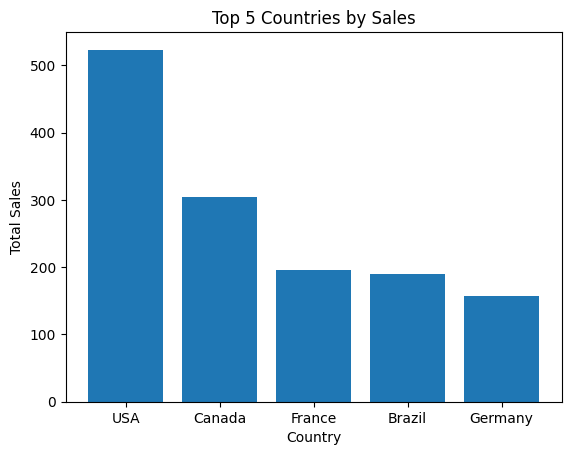

In [23]:
from langchain import hub
from langchain.agents import create_structured_chat_agent

llm = ChatOpenAI(model="gpt-4o-mini")

prompt = hub.pull("hwchase17/structured-chat-agent")

agent = create_structured_chat_agent(
    llm, tools, prompt
)
agent_executor = AgentExecutor(
    agent=agent, tools=tools, verbose=True, handle_parsing_errors=True
)
agent_executor.invoke({"input": "Chinook 데이터베이스에서 매출 상위 5개 국가를 추출하여 pandas 데이터프레임으로 저장하세요. 그런 다음 matplotlib 바 차트를 반환하세요. 결과를 현재 작업 디렉터리에 figure.png로 저장하세요."})